# Optimize denovo reference
    This script uses scripts provided by dDocent to de novo assembly in CD-HIT
    https://www.ddocent.com/assembly/
    
    Run dDocent first with basic commands. Use individuals retained from filtering to make assembly
    
## REDONE on 12/20/2022  

This is after most analyses. Want to be more strict about clustering simularity. Want to thoughtfully select individuals based off what is known

## For reference throughout this notebook:

**All unformatted text part of Trevor's original workflow.  Seth's annotations follow these rules**:  
+ *this text* = conceptual explanation of code<br>
+ <span style="color:purple">**this text**</span> = logical `code` explanation<br>
+ <span style="color:tomato">*this text*</span> = questions, uncertainties, parenthetical comments<br>
&nbsp;<br>

With that defined let's create a new section to talk about organization in this notebook...
<hr>
<hr>
    
## Sections:

1. Exploring file contents and formatting to run `RefOpt.sh`
2. Building slurm scripts to parallel run `RefOpt.sh`
3. Interpreting `RefOpt` output for determing optimal c parameter
4. Building slurm scripts to parallel run `MapOpt.sh`
5. Compare k parameters from `MapOpt` to create optimal assembly from full dataset

### 1.1 Import packages

In [1]:
import sys
import ipyparallel as ipp
import os
from os import environ
import gzip
import warnings
import pandas as pd
import numpy as np
import scipy as sp
import glob
import re
import random

*Just defining directory where we are working and checking with `pwd`*

In [2]:
root = "/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO"

In [3]:
cd $root

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO


In [4]:
pwd

'/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO'

### 1.2 Make assembly refopt dir and assign fastq dir

*directory itself is called 'assembly' while 'assembly_dir' is variable name presumably to avoid some variable/function confusion*

In [5]:
!mkdir assembly

mkdir: cannot create directory ‘assembly’: File exists


In [6]:
!mkdir assembly/refOpt2

In [7]:
assembly_dir = os.path.join(root,'assembly')

In [8]:
refOpt_dir = os.path.join(assembly_dir,'refOpt2')

In [9]:
fq_dir = '/data/gpfs/assoc/denovo/tfaske/rabbit/full/demult/fastq'

### 1.5 Sample random fastq for optimizer  

using pca_df.csv from old analyses, select individuals. Do it in R, easier for me.

Select XXXX individuals. equal porportions of groups. 

*Idea here is to reduce the data we are initializing `RefOpt` and `MapOpt` on for efficiency purposes.  These test runs are just to determine optimal c, k1, and k2 parameters to build a final assembly for mapping.  Both scripts are huge alignment processes and would take way too long to run on full dataset.  Using 1 individual from eqach population with the most reads is a nice compromise. The final assembly will use **full** dataset.*

In [10]:
cd $root

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO


In [11]:
%load_ext rpy2.ipython

In [12]:
%%R 

setwd('/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO')

pca_df <- read.csv('data/pca_df.csv')

dim(pca_df)
#print(table(paste0(pca_df$Variety,'_',pca_df$Color))

[1] 585  24


In [14]:
%%R

pca_known <- pca_df[-which(is.na(pca_df$Ssp)),]
group <- c('arenaria','bigelovii','graveolens','iridis','juncea','mohavensis','nana','nitida','turbinata')


pca_group <- pca_known[which(pca_known$Variety %in% group),]
pca_nongroup <- pca_known[-which(pca_known$Variety %in% group),]

print(dim(pca_group))
print(dim(pca_nongroup))

table(pca_nongroup$Color)

#pca_known <- pca_df[-which(is.na(pca_df$Ssp)),]
#pca_known$Variety <- as.character(pca_known$Variety)
#pca_known$Color <- as.character(pca_known$Color)
#dim(pca_known)
#table(pca_known$Variety)
#pca_known$var_col <- as.character(paste0(pca_known$Variety,'_',pca_known$Color))
#table(pca_known$var_col)

[1] 75 24
[1] 435  24

 green   grey hybrid 
    71    263    101 


### Select equal groups: 75 group, 71 green, 101 hybrid, 263 grey

In [21]:
%%R

numbers <- c(75,71,101,263)/25
print(numbers)

keep_group <- sample(pca_group$All,5)
keep_green <- sample(pca_nongroup$All[which(pca_nongroup$Color == 'green')],6)
keep_hyb <- sample(pca_nongroup$All[which(pca_nongroup$Color == 'hybrid')],4)       
keep_grey <- sample(pca_nongroup$All[which(pca_nongroup$Color == 'grey')],10)  

keep_fq <- c(keep_group,keep_green,keep_hyb,keep_grey)
keep_fq

[1]  3.00  2.84  4.04 10.52
 [1] "EN_SJ_11" "EN_JT_4"  "EN_RS_1"  "EN_NI_5"  "EN_CI_4"  "EN_EW_12"
 [7] "EN_DT_5"  "EN_BC_8"  "EN_AH_15" "EN_GO_4"  "EN_WA_3"  "EN_UO_3" 
[13] "EN_OO_6"  "EN_OO_5"  "EN_RH_1"  "EN_HO_4"  "EN_BM_21" "EN_BV_30"
[19] "EN_DC_7"  "EN_PL_22" "EN_DH_25" "EN_PL_17" "EN_BM_19" "EN_PL_5" 
[25] "EN_DH_19"


In [23]:
%%R
#keep_fq
### mv keep_fq to refOpt

fq_dir <- '/data/gpfs/assoc/denovo/tfaske/rabbit/full/demult/fastq/'
refOpt_dir <- '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/assembly/refOpt2/'

#cp_cmd <- array(NA,dim=length(keep_fq))
for (i in 1:length(keep_fq)){
    #cp_cmd[i] <- paste0('cp ',fq_dir,keep_fq[i],'.F.fq.gz ',refOpt_dir)
    cmd <- paste0('cp ',fq_dir,keep_fq[i],'.F.fq.gz ',refOpt_dir)
    system(cmd)
}
#cp_cmd

In [24]:
!ls {refOpt_dir}/*gz | wc -l 

25


# 2. Make a slurm script to run ReferenceOpt.sh   

ReferenceOpt.sh minK1 maxK1 minK2 maxK2 Assembly_Type Processors  
    
#### NOTE: must run dDocent to at least trim first 

### Understanding ReferenceOpt.sh (in process of transferring notes)

Much of the details can't be found here: http://www.ddocent.com/assembly/<br>
This script is written by Jon Puritz to determine what c parameter is optimal for reference assembly.  The steps below are repeatedly iteratively with all c values 0.80-0.98 and 0.02 increments.  Each of these c parameters are also run with each combination of k1 and k2 parameters based on a set min-max range (here we use 4-10 for both).  k1 indicates the minimum number of times a contig must occur *within* an inidividual to be used in clustering while k2 indicates minimum number of individuals a contig must occur in to be included.  c parameter used to set cluster similarity threshold.  Output is designed to identify point of inflection where data is goes from reliable to erroneous.  k parameter ranges simply used to ensure that interpretation of inflection point isn't biased by k pairing. The workflow generally follows:  
+ Read trimming
+ Initial clustering with low similarity via `CD-HIT`
    + Original script may have called for 80% which is very loose but is intended to do initial rough grouping to reduce downstream complexity.  <span style="color:tomato">Need to check this script as it may have been modified by Trevor to use different parameters at clustering steps</span>
+ Clustering with `rainbow`
+ Mapping of forward reads with `bwa`
    + If using paired-end reads, adds additional step to compare clustering of `CD-HIT` with reverse reads.  If clustered accurately, clustering of reverse and forward reads should agree

In [25]:
refOpt = '/data/gpfs/assoc/denovo/src/refOpt/./ReferenceOpt.sh'
refOpt_dir = os.path.join(assembly_dir,'refOpt2')

In [26]:
cd $refOpt_dir

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/assembly/refOpt2


In [27]:
### select options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
jobname = 'ERNA_refOpt'
time = '4-00:00:00' #time limit 4 days
minK1 = 4
maxK1 = 10
minK2 = 4
maxK2 = 10
Type = 'SE' 
cpus = 64
mem_cpu = 2500
email = 'tfaske@nevada.unr.edu'

In [28]:
def write_refOpt_sh(account,partition,cpus,mem_cpu,email,refOpt,minK1,maxK1,minK2,maxK2,Type):
    with open("run_refOpt2.sh", "w") as o:
        o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name %s
#SBATCH --output output_refOpt.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (account,partition,int(cpus),int(mem_cpu),jobname,email))

        #ReferenceOpt.sh minK1 maxK1 minK2 maxK2 Assembly_Type Processors
        o.write("%s %d %d %d %d %s %d" % (refOpt,minK1,maxK1,minK2,maxK2,Type,cpus))

In [29]:
write_refOpt_sh(account,partition,cpus,mem_cpu,email,refOpt,minK1,maxK1,minK2,maxK2,Type)

# run refOpt.sh in slurm
    cd /data/gpfs/assoc/denovo/ERNA/assembly/refOpt
    source activate ddocent_env
    sbatch run_refOpt.sh

# Visualize kopt from refOpt

In [53]:
cd $refOpt_dir

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/assembly/refOpt2


In [54]:
!tail output_refOpt.txt

The top three most common number of contigs
X	Contig number
2	7642
2	7402
2	4184
The top three most common number of contigs (with values rounded)
X	Contig number
11	3500
11	2600
10	4000


In [55]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


R[write to console]: Use suppressPackageStartupMessages() to eliminate package startup
messages




── Column specification ────────────────────────────────────────────────────────
cols(
  k1 = col_double(),
  k2 = col_double(),
  c = col_double(),
  contig = col_double()
)



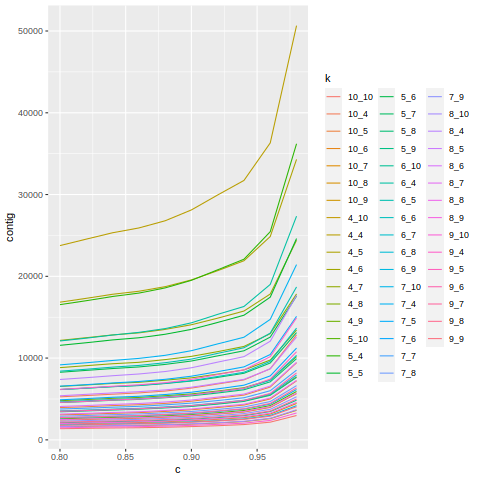

In [56]:
%%R
library(readr)
library(ggplot2)

kopt <- read_table2('kopt.data',col_names = c('k1','k2','c','contig'))
kopt$k <- paste0(kopt$k1,'_',kopt$k2)

ggplot(data=kopt,aes(x=c,y=contig,colour=k)) + 
  geom_line() 

c = .94 is the winner!, look where it starts to tick up

# MapOpt now!!!
    This script assembles references across cutoff values and then maps 20 random samples and evaluates mappings to the reference, along with number of contigs and coverage.
    
    Moves fastq files from refOpt, runs dDocent to get trimmed files
    
    choose mapOpt sim from kopt above: 94 add (e.g. 92,94,96)

In [30]:
cd $assembly_dir

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/assembly


In [31]:
!mkdir mapOpt2

In [33]:
mapOpt_dir = os.path.join(assembly_dir,'mapOpt2')
assert mapOpt_dir

In [41]:
sim_val = [90,92,94,96]

In [42]:
for sim in sim_val:
    mapsim = "mapOpt2/mapOpt%d" % (sim)
    !mkdir $mapsim

mkdir: cannot create directory ‘mapOpt2/mapOpt92’: File exists
mkdir: cannot create directory ‘mapOpt2/mapOpt94’: File exists
mkdir: cannot create directory ‘mapOpt2/mapOpt96’: File exists


In [43]:
### cp fastq from refOpt
fq_files = !find $refOpt_dir -name '*fq.gz'
fq_files = [os.path.abspath(x) for x in fq_files]
len(fq_files),fq_files[0]

(50,
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/assembly/refOpt2/EN_OO_5.F.fq.gz')

In [44]:
for fq in fq_files:   
    for sim in sim_val:
        mapsim = "mapOpt2/mapOpt%d" % (sim)
        !cp $fq $mapsim

In [45]:
for sim in sim_val:
    mapsim = "mapOpt2/mapOpt%d" % (sim)
    logfiles = os.path.join(refOpt_dir,'logfiles')
    !cp -r $logfiles $mapsim

In [46]:
src_dir = '/data/gpfs/assoc/denovo/src/refOpt/./'
mapOpt_sh = []
for sim in sim_val:
    sh = src_dir + "Map%d.sh"%(sim)
    mapOpt_sh.append(sh)

In [47]:
len(mapOpt_sh), mapOpt_sh

(4,
 ['/data/gpfs/assoc/denovo/src/refOpt/./Map90.sh',
  '/data/gpfs/assoc/denovo/src/refOpt/./Map92.sh',
  '/data/gpfs/assoc/denovo/src/refOpt/./Map94.sh',
  '/data/gpfs/assoc/denovo/src/refOpt/./Map96.sh'])

In [48]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 1 days
cpus = 16
mem_cpu = 9000

#RefMapOpt minK1 maxK1 minK2 maxK2 cluster_similarity Assembly_Type Num_of_Processors
minK1 = 4
maxK1 = 10
minK2 = 4
maxK2 = 10
Type = 'SE' 

In [49]:
cd $mapOpt_dir

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/assembly/mapOpt2


In [50]:
def write_mapOpt_sh(account,partition,time,cpus,mem_cpu,sim,email,mapOpt_dir,
                    mapOpt_sh,sim_val,minK1,maxK1,minK2,maxK2,Type):
    for i in range(0,len(mapOpt_sh)):
        sh = mapOpt_sh[i]
        sim = sim_val[i]
        with open("mapOpt%d/run_mapOpt%d.sh" % (sim,sim), "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name mapOpt%d
#SBATCH --output output_mapOpt%d.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s

cd %s/mapOpt%d\n\n""" % (account,partition,time,int(cpus),int(mem_cpu),sim,sim,email,mapOpt_dir,sim))

        #RefMapOpt minK1 maxK1 minK2 maxK2 cluster_similarity Assembly_Type Num_of_Processors
            o.write("""%s %d %d %d %d 0.%d %s %d"""% (sh,minK1,maxK1,minK2,maxK2,sim,Type,cpus))

In [51]:
write_mapOpt_sh(account,partition,time,cpus,mem_cpu,sim,email,mapOpt_dir,
                    mapOpt_sh,sim_val,minK1,maxK1,minK2,maxK2,Type)

In [52]:
mapShells = !find $mapOpt_dir -name 'run_map*.sh'
mapShells

['/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/assembly/mapOpt2/mapOpt94/run_mapOpt94.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/assembly/mapOpt2/mapOpt96/run_mapOpt96.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/assembly/mapOpt2/mapOpt90/run_mapOpt90.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/assembly/mapOpt2/mapOpt92/run_mapOpt92.sh']

In [83]:
def write_sbatch_mapOpt(mapShells):
         with open("sbatch_mapOpt.sh", "w") as o:
            o.write("""#!/usr/bin/env bash \n""")
            for sh in mapShells:
                o.write("""sbatch %s\n""" % (sh))

In [84]:
write_sbatch_mapOpt(mapShells)

# Run all mapOpt*sh ()
    cd /data/gpfs/assoc/denovo/PHHA/assembly/mapOpt
    source activate ddocent_env
    bash sbatch_mapOpt.sh

# Read in mapping results and make decision

In [60]:
cd $mapOpt_dir

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/assembly/mapOpt2


In [61]:
mapResults = !find  -name 'mapping*results'
mapResults

['./mapOpt94/mapping94.results',
 './mapOpt96/mapping96.results',
 './mapOpt90/mapping90.results',
 './mapOpt92/mapping92.results']

In [62]:
for mR in mapResults:
    print(mR)
    !cat $mR
    print('\n')

./mapOpt94/mapping94.results
Cov	Non0Cov	Contigs	MeanContigsMapped	K1	K2	SUM Mapped	SUM Properly	Mean Mapped	Mean Properly	MisMatched
47.5191	52.4749	31728	28724.7	4	4	28646942	0	1.50773e+06	0	0
66.433	71.4755	21906	20357.1	4	5	27651620	0	1.45535e+06	0	0
89.5717	94.9381	15755	14867.4	4	6	26814539	0	1.41129e+06	0	0
119.407	125.167	11426	10903.9	4	7	25924777	0	1.36446e+06	0	0
154.696	161.02	8552	8221.05	4	8	25139238	0	1.32312e+06	0	0
201.042	208.233	6379	6164.79	4	9	24370299	0	1.28265e+06	0	0
259.912	268.52	4762	4616.63	4	10	23521212	0	1.23796e+06	0	0
66.2327	71.4474	22094	20463.1	5	4	27804821	0	1.46341e+06	0	0
92.8642	98.2037	15243	14404.7	5	5	26896825	0	1.41562e+06	0	0
125.894	131.489	10894	10426.6	5	6	26060592	0	1.37161e+06	0	0
163.196	169.134	8142	7855.16	5	7	25249192	0	1.3289e+06	0	0
210.212	216.774	6127	5942.21	5	8	24475405	0	1.28818e+06	0	0
266.49	273.909	4706	4581.26	5	9	23832994	0	1.25437e+06	0	0
337.288	346.267	3591	3501.53	5	10	23019204	0	1.21154e+06	0	0
87.5661	93.2249	16314	



./mapOpt92/mapping92.results
Cov	Non0Cov	Contigs	MeanContigsMapped	K1	K2	SUM Mapped	SUM Properly	Mean Mapped	Mean Properly	MisMatched
51.3531	56.6801	29950	27134.2	4	4	30761562	0	1.53808e+06	0	0
71.5027	76.9755	20691	19220.9	4	5	29590665	0	1.47953e+06	0	0
96.0151	101.834	14884	14038.6	4	6	28583710	0	1.42919e+06	0	0
128.136	134.429	10791	10291.1	4	7	27656866	0	1.38284e+06	0	0
166.255	173.23	8040	7721.55	4	8	26737163	0	1.33686e+06	0	0
216.697	224.656	5973	5767.9	4	9	25890943	0	1.29455e+06	0	0
281.926	291.667	4431	4290.4	4	10	24989928	0	1.2495e+06	0	0
71.7226	77.299	20799	19283.5	5	4	29836624	0	1.49183e+06	0	0
100.094	105.798	14361	13579.5	5	5	28750947	0	1.43755e+06	0	0
135.273	141.256	10273	9835.35	5	6	27795885	0	1.38979e+06	0	0
176.379	182.796	7642	7373.6	5	7	26961218	0	1.34806e+06	0	0
227.56	234.743	5731	5556.8	5	8	26087435	0	1.30437e+06	0	0
289.747	297.939	4376	4258.65	5	9	25364466	0	1.26822e+06	0	0
368.706	378.706	3316	3232.15	5	10	24459944	0	1.223e+06	0	0
94.6635	100.67	15349	1441

In [63]:
%%R 
library(readr)
library(data.table)
setwd('/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/assembly/mapOpt')

mapping92 <- read_table2('mapOpt92/mapping92.results')
mapping92$k <- paste0(mapping92$K1,'_',mapping92$K2)
mapping92$sim <- '92'
mapping92$ratio <- abs( scale(mapping92$SUM_1) / (scale(mapping92$MeanContigsMapped) / scale(mapping92$Cov) ) ) 


mapping94 <- read_table2('mapOpt94/mapping94.results')
mapping94$k <- paste0(mapping94$K1,'_',mapping94$K2)
mapping94$sim <- '94'
mapping94$ratio <- abs( scale(mapping94$SUM_1) / (scale(mapping94$MeanContigsMapped) / scale(mapping94$Cov) ) ) 

mapping96 <- read_table2('mapOpt96/mapping96.results')
mapping96$k <- paste0(mapping96$K1,'_',mapping96$K2)
mapping96$sim <- '96'
mapping96$ratio <- abs( scale(mapping96$SUM_1) / (scale(mapping96$MeanContigsMapped) / scale(mapping96$Cov) ) )

#print(mapping92)
#print(mapping94)
#print(mapping96)

#map_df
map_df <- rbindlist(list(mapping92,mapping94,mapping96))
head(map_df)

R[write to console]: data.table 1.14.2 using 32 threads (see ?getDTthreads).  Latest news: r-datatable.com




── Column specification ────────────────────────────────────────────────────────
cols(
  Cov = col_double(),
  Non0Cov = col_double(),
  Contigs = col_double(),
  MeanContigsMapped = col_double(),
  K1 = col_double(),
  K2 = col_double(),
  SUM = col_double(),
  Mapped = col_double(),
  SUM_1 = col_double(),
  Properly = col_double(),
  Mean = col_double(),
  Mapped_1 = col_character(),
  Mean_1 = col_character(),
  Properly_1 = col_character(),
  MisMatched = col_character()
)



R[write to console]: Warning:
R[write to console]:  49 parsing failures.
row col   expected     actual                         file
  1  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
  2  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
  3  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
  4  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
  5  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
... ... .......... .......... ............................
See problems(...) for more details.





── Column specification ────────────────────────────────────────────────────────
cols(
  Cov = col_double(),
  Non0Cov = col_double(),
  Contigs = col_double(),
  MeanContigsMapped = col_double(),
  K1 = col_double(),
  K2 = col_double(),
  SUM = col_double(),
  Mapped = col_double(),
  SUM_1 = col_double(),
  Properly = col_double(),
  Mean = col_double(),
  Mapped_1 = col_character(),
  Mean_1 = col_character(),
  Properly_1 = col_character(),
  MisMatched = col_character()
)



R[write to console]: Warning:
R[write to console]:  49 parsing failures.
row col   expected     actual                         file
  1  -- 15 columns 11 columns 'mapOpt94/mapping94.results'
  2  -- 15 columns 11 columns 'mapOpt94/mapping94.results'
  3  -- 15 columns 11 columns 'mapOpt94/mapping94.results'
  4  -- 15 columns 11 columns 'mapOpt94/mapping94.results'
  5  -- 15 columns 11 columns 'mapOpt94/mapping94.results'
... ... .......... .......... ............................
See problems(...) for more details.





── Column specification ────────────────────────────────────────────────────────
cols(
  Cov = col_double(),
  Non0Cov = col_double(),
  Contigs = col_double(),
  MeanContigsMapped = col_double(),
  K1 = col_double(),
  K2 = col_double(),
  SUM = col_double(),
  Mapped = col_double(),
  SUM_1 = col_double(),
  Properly = col_double(),
  Mean = col_double(),
  Mapped_1 = col_character(),
  Mean_1 = col_character(),
  Properly_1 = col_character(),
  MisMatched = col_character()
)



R[write to console]: Warning:
R[write to console]:  49 parsing failures.
row col   expected     actual                         file
  1  -- 15 columns 11 columns 'mapOpt96/mapping96.results'
  2  -- 15 columns 11 columns 'mapOpt96/mapping96.results'
  3  -- 15 columns 11 columns 'mapOpt96/mapping96.results'
  4  -- 15 columns 11 columns 'mapOpt96/mapping96.results'
  5  -- 15 columns 11 columns 'mapOpt96/mapping96.results'
... ... .......... .......... ............................
See problems(...) for more details.




        Cov  Non0Cov Contigs MeanContigsMapped K1 K2      SUM Mapped   SUM_1
1:  57.6300  62.4873   30371          27953.20  4  4 31506079      0 1750340
2:  81.5139  86.7423   20613          19332.70  4  5 30245906      0 1680330
3: 111.5040 117.4640   14448          13689.70  4  6 29000310      0 1611130
4: 150.3840 157.3680   10324           9849.44  4  7 27948893      0 1552720
5: 200.6040 208.8080    7427           7124.44  4  8 26821577      0 1490090
6: 266.3970 276.6210    5338           5134.39  4  9 25601309      0 1422290
   Properly Mean Mapped_1 Mean_1 Properly_1 MisMatched   k sim     ratio
1:        0    0     <NA>   <NA>       <NA>       <NA> 4_4  92 0.8342381
2:        0    0     <NA>   <NA>       <NA>       <NA> 4_5  92 0.9767031
3:        0    0     <NA>   <NA>       <NA>       <NA> 4_6  92 1.0731808
4:        0    0     <NA>   <NA>       <NA>       <NA> 4_7  92 1.2010952
5:        0    0     <NA>   <NA>       <NA>       <NA> 4_8  92 1.6278578
6:        0    0     <N

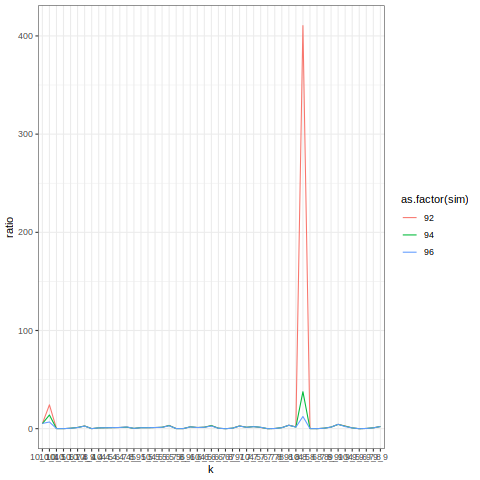

In [64]:
%%R
ggplot(data=map_df,aes(x=k,y=ratio,color=as.factor(sim))) + 
    geom_line(aes(group=as.factor(sim))) + theme_bw()

In [65]:
%%R 
colMeans(map_df[,c(1:7,9)])

              Cov           Non0Cov           Contigs MeanContigsMapped 
     2.989131e+02      3.065234e+02      7.274401e+03      6.971201e+03 
               K1                K2               SUM             SUM_1 
     7.000000e+00      7.000000e+00      2.542996e+07      1.413615e+06 


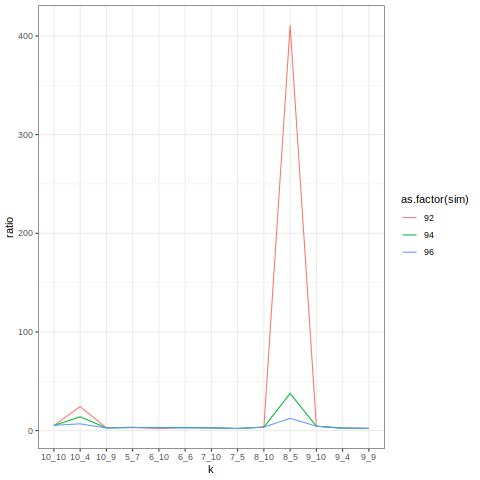

In [66]:
%%R
map_top <- map_df[which(map_df$ratio > quantile(map_df$ratio,probs=.75)),]

#SUM Properly
ggplot(data=map_top,aes(x=k,y=ratio,color=as.factor(sim))) + 
    geom_line(aes(group=as.factor(sim))) + theme_bw()

In [93]:
%%R
names(map_df)

 [1] "Cov"               "Non0Cov"           "Contigs"          
 [4] "MeanContigsMapped" "K1"                "K2"               
 [7] "SUM"               "Mapped"            "SUM_1"            
[10] "Properly"          "Mean"              "Mapped_1"         
[13] "Mean_1"            "Properly_1"        "MisMatched"       
[16] "k"                 "sim"               "ratio"            


In [68]:
%%R
map_df[which(map_df$k %in% c('5_4','5_5','5_6','8_5')),c(1:7,9,17,18)]

         Cov  Non0Cov Contigs MeanContigsMapped K1 K2      SUM   SUM_1 sim
 1:  81.7934  86.8310   20685          19445.70  5  4 30455609 1691980  92
 2: 116.4660 121.9070   13948          13299.90  5  5 29242397 1624580  92
 3: 159.3760 165.3380    9793           9422.78  5  6 28096817 1560930  92
 4: 233.3140 239.1320    6511           6344.72  8  5 27348156 1519342  92
 5:  75.9010  80.8343   21863          20489.20  5  4 28211481 1659500  94
 6: 107.6810 113.0080   14773          14050.40  5  5 27044878 1590880  94
 7: 147.6980 153.5550   10395           9980.59  5  6 26103008 1535470  94
 8: 211.8920 217.9320    7014           6811.24  8  5 25269189 1486420  94
 9:  63.6802  67.8607   24921          23343.70  5  4 30153731 1587040  96
10:  90.8298  95.1894   16817          16018.70  5  5 29023937 1527580  96
11: 123.9620 128.6580   11904          11450.30  5  6 28039690 1475770  96
12: 175.5850 180.3480    8170           7945.53  8  5 27259451 1434710  96
         ratio
 1:   1.01

# Map results 
    sim=92 K1=8 k2=5 WINNER    
    remake reference in fastq using these parameters. Move reference.fasta to assembly dir